In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import quad
import math

plt.rcParams.update({
	'text.usetex': True,
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	'axes.labelweight': 'normal',
	'axes.linewidth': 1.5,
	'xtick.major.width': 1.5,
	'xtick.major.size': 10.0,
	'xtick.minor.size': 5.0,
	'ytick.major.width': 1.5,
	'ytick.major.size': 10.0,
	'ytick.minor.size': 5.0,
	'font.size': 30,
    'figure.figsize' : (10,6)})
plt.rcParams.update({'font.size': 20})

kb = 1.380649e-23#J/K
m=40*1.66*1e-27
T=3
mu = 30*kb*T
A=(3.5e+31)/1.0234366462120648
beta = 1/(kb*T)
n=1
meanTH = (3/5)*n*mu

def f(epsilon,T):
    beta    = 1/(kb*T)
    num   = A*np.sqrt(epsilon)
    den   = np.exp(beta*(epsilon-mu)) + 1.0
    return num/den

def f3K(epsilon):
    return f(epsilon, 3)

def exp_val(epsilon):
	return epsilon*f(epsilon,3)

def moment_2(epsilon):
	return epsilon*epsilon*f(epsilon,3)

def gauss(x, gmean, gsigma):
    pref = 1/(np.sqrt(2*np.pi)*gsigma)
    return pref*np.exp(-(x-gmean)*(x-gmean)/(2*gsigma*gsigma))

# Task 1

Verify that the integral is 1

In [3]:
I = quad(f3K, 0 , 2*mu)
I = I[0]
ExpVal = quad(exp_val, 0, 2*mu)
ExpVal = ExpVal[0]
varPDF = quad(moment_2,0,2*mu)[0]-ExpVal**2

print(" The integral of f:\t" ,  I ,"\n The exp.value: \t" , ExpVal, "\n The theoretical :\t", meanTH
    , "\n The variance  :\t", varPDF)

 The integral of f:	 1.0000000000000002 
 The exp.value: 	 7.496301612517094e-22 
 The theoretical :	 7.4555046e-22 
 The variance  :	 1.094468933417454e-43


Define the sample generator

In [4]:
def Egenerator(N, Temp):
    xf=np.linspace(0,2*mu,1000)
    yf=f(xf, Temp)
    ymax = np.max(yf)*1.01
    p = 1/((2*mu)*ymax) # Probability that an event is recorded
    Nrand = int(N/(p-0.001)) 
    ok = 0
    
    while ok == 0 :
        x = np.random.rand(Nrand)*(2*mu)
        y = np.random.rand(Nrand)*ymax
        data = x[np.where(y<=f(x,Temp))]
        if len(data)>=N:
            ok = 1
    data = data[:int(N)]
    return data

Just a more complete generator for the graph

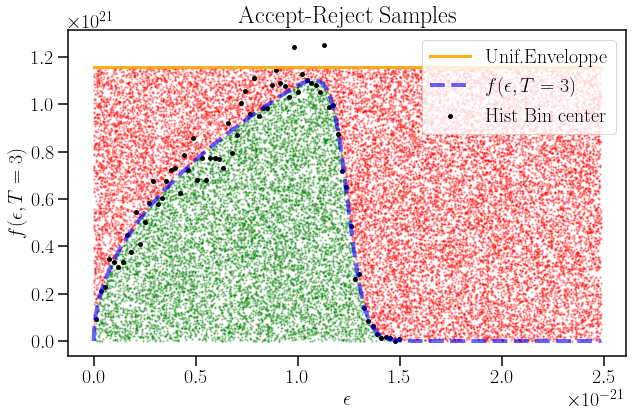

In [5]:
nEvents = 1e4
listAccX =[]
listAccY =[]
listRejX =[]
listRejY =[]
interval= (0, 2*mu)
fmax    = np.max(f(np.linspace(*interval,1000),3))*1.05
gen     = np.random.default_rng()
while len(listAccX)<nEvents :
    x       = gen.uniform(*interval)
    y       = gen.uniform(0, fmax)
    if y <= f(x, T):
        listAccX.append(x)
        listAccY.append(y)
    else:
        listRejX.append(x)     
        listRejY.append(y) 

cc, ee = np.histogram(listAccX, density=True, bins = 70)
wi = ee[1]-ee[0]
xC = ee[:-1]+wi/2


xfunc = np.linspace(0,2*mu,1000)
yfunc = f(xfunc,3)

plt.scatter(listAccX,listAccY       , s = 2 , color = "green"   , alpha = 0.3)
plt.scatter(listRejX,listRejY       , s = 2 , color = "red"     , alpha = 0.3)
plt.plot([0,2*mu],[fmax,fmax]   , lw =3 , color = "orange"  , alpha = 0.9, label = "Unif.Enveloppe")
plt.scatter(xC,cc            , s = 15,  color = "black", label = "Hist Bin center")
#plt.fill([1.51e-21,2*mu,2*mu,1.51e-21],[0.7e21,0.7e21,fmax*1.01,fmax*1.01], color = "white", alpha = 0.8)
plt.plot(xfunc,yfunc, "--", color = "blue", alpha = 0.6,lw = 4, label = r"$f(\epsilon, T=3)$")

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$f(\epsilon, T=3)$")
plt.title("Accept-Reject Samples")
plt.legend()

Compute the mean via two ways : manually and numpy

The mean is :  7.478993024031683e-22  The theoretial mean is :  7.496301612517094e-22  The mean computed with numpy is :  7.479165486413953e-22


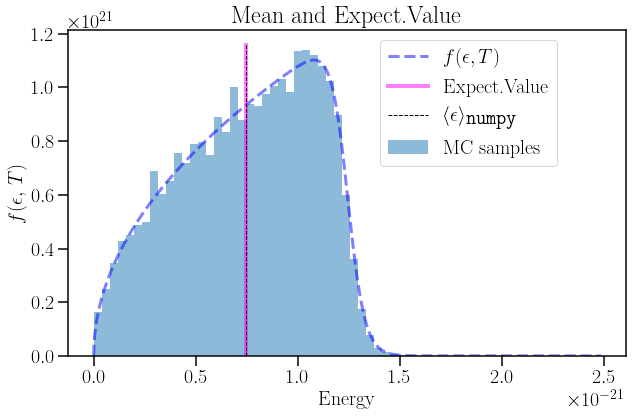

In [6]:
data = Egenerator(1e4, 3)
content,bin_edges, _ = plt.hist(data, density=True, bins = 40, alpha = 0.5, label = "MC samples")
binWidth = (bin_edges[1] - bin_edges[0])
xCoords = bin_edges[:-1] + binWidth/2
#plt.scatter(list(xCoords), np.zeros(len(xCoords)), color = "red", label = "Bin center")

#compute the mean explicitely
mean = np.sum(content*xCoords) *binWidth
meanTH = (3/5)*n*mu
m = np.mean(data)


plt.plot(xfunc,yfunc                , "--"  , lw = 3, color = "blue"    , alpha = 0.5   , label = r"$f(\epsilon, T)$")
plt.plot([meanTH, meanTH], [0, fmax]        , lw = 4, color = "magenta" , alpha = 0.5   , label = "Expect.Value")
plt.plot([m, m], [0, fmax]          , '--'  , lw = 1, color = "black"  , alpha = 1     , label = r"$\langle\epsilon\rangle_{\texttt{numpy}}$")

plt.xlabel("Energy")
plt.ylabel("$f(\epsilon,\,T)$")
plt.legend(bbox_to_anchor=[0.54, 0 ,0,1])
plt.title("Mean and Expect.Value")

print("The mean is : " ,mean, " The theoretial mean is : " , ExpVal, " The mean computed with numpy is : ", m)


Compare them, they are the same

In [7]:
print(mean/(kb*T))
print(m/(kb*T))

18.05670865424324
18.05712503422654


The higher moments

In [8]:
v       = np.var(data)
s       = stats.skew(data)
k       = stats.kurtosis(data)
stdev   = np.sqrt(v)
stdev_APP = stdev

print(" variance = ", v , "\n skewness = ", s , "\n kurtosis = ", k, "\n stand dev = ", stdev)

 variance =  1.0940578688240014e-43 
 skewness =  -0.2760895184705866 
 kurtosis =  -0.9287148068175015 
 stand dev =  3.307654559992626e-22


# Task 2

a) Take Nexp = 1 and show the law of large numbers based on the data points you generated.

Now we take the data points we managed to get. They are all distributed according to $f$, with a mean of $18\cdot k_B T$ and a variance $var \approx 1.07 \cdot 10^{-43}$

If we want to show the laws of large numbers, we can show that if we progressively compute the mean for a given number of samples ($N_{exp}=1$), then the average will converge to a number, which should be the mean.

In [11]:
N=1e7
data = Egenerator(N,3)
l = len(data)
steps = 100

listAverage = np.zeros(int(N/steps))
for i in range(int(l/steps)):
    moy = np.mean(data[:i+1])
    listAverage[i] = moy
xMean = np.linspace(0,N,int(l/steps))

Text(0.5, 1.0, 'Convergence of mean')

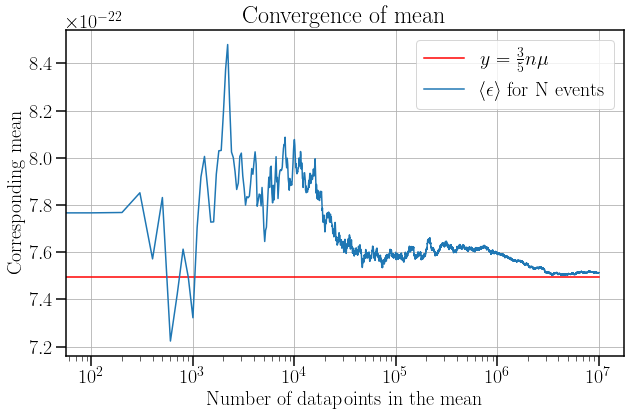

In [12]:
plt.plot([0,N],[ExpVal,ExpVal], color = "red", label = r"$y = \frac{3}{5}n\mu$")
plt.plot(xMean, listAverage, label = r"$\langle\epsilon\rangle $ for N events ")

plt.xlabel("Number of datapoints in the mean")
plt.ylabel("Corresponding mean")
plt.legend()
plt.grid()
plt.semilogx()
plt.title("Convergence of mean")

If we take the ratio divided by 18, it converges asymptotically to 1

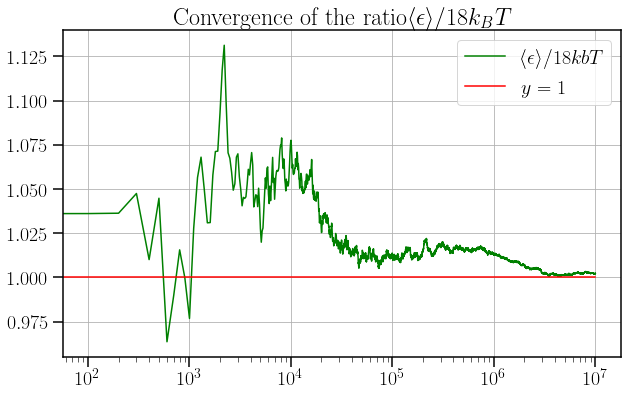

In [13]:
ratio = [listAverage/(ExpVal) for listAverage in listAverage]
plt.plot(xMean, ratio, color = "green", label = r"$\langle\epsilon\rangle/18 kb T$")
plt.plot([0,N],[1,1], color = "red", label = "$y = 1$")
plt.semilogx()
plt.grid()
plt.title("Convergence of the ratio"+r"$\langle\epsilon\rangle/18k_BT$")
plt.legend()


b) Take Nexp >> 1 and show the validity of the central limit theorem for the mean :

We will take for example 2000 experiment and every time, we will compute the mean and put it in a list

In the end, we put it in a histogram and see if it is a Gaussian.

In [14]:
N=1e4
Nexp = 1e4

k=1
listMean = []
listVar = []
while k<=Nexp :
    dat     = Egenerator(N,3)
    mean2   = np.mean(dat)
    var2    = np.var(dat)
    listMean.append(mean2)
    listVar.append(var2)
    k = k+1

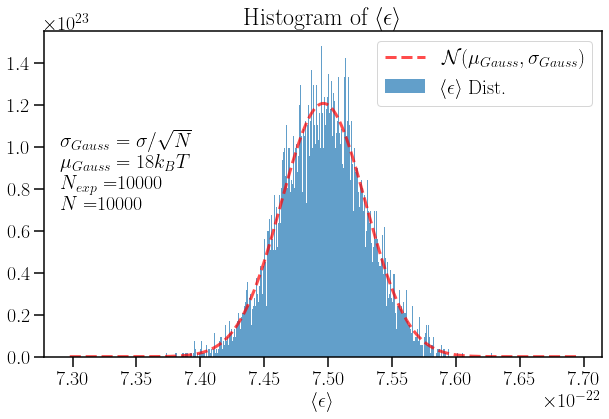

In [15]:
sigmaCLT = np.sqrt(varPDF)/np.sqrt(N)

xplot = np.linspace(ExpVal-6*sigmaCLT, ExpVal+6*sigmaCLT, 1000)
yplot = gauss(xplot, ExpVal, sigmaCLT)

plt.hist(listMean, density=True, bins = 500  , alpha = 0.7      , label = r"$\langle\epsilon\rangle$ Dist.")
plt.plot(xplot,yplot, "--"  , color ="red"  , alpha = 0.7 , lw = 3, label = r"$\mathcal{N}(\mu_{Gauss},\sigma_{Gauss})$")
plt.title(r"Histogram of $\langle\epsilon\rangle$" )
plt.xlabel(r"$\langle\epsilon\rangle$")


plt.text(meanTH-5*sigmaCLT, 10e22, "$\sigma_{Gauss} = \sigma/\sqrt{N}$"        , horizontalalignment='left')
plt.text(meanTH-5*sigmaCLT, 9e22, "$\mu_{Gauss} = 18k_BT$"                  , horizontalalignment='left')
plt.text(meanTH-5*sigmaCLT, 8e22, "$N_{exp}=$"+ str("{:.0f}".format(Nexp))  , horizontalalignment='left')
plt.text(meanTH-5*sigmaCLT, 7e22, '$N=$'+ str("{:.0f}".format(N))           , horizontalalignment='left')

plt.legend()

We can also normalise the Gaussian

(array([0.00619369, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00619369, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00619369, 0.00619369, 0.        , 0.        ,
        0.        , 0.00619369, 0.        , 0.        , 0.        ,
        0.        , 0.00619369, 0.        , 0.00619369, 0.        ,
        0.        , 0.00619369, 0.00619369, 0.00619369, 0.00619369,
        0.        , 0.        , 0.01238738, 0.00619369, 0.00619369,
        0.00619369, 0.        , 0.00619369, 0.        , 0.02477477,
        0.01238738, 0.        , 0.        , 0.00619369, 0.00619369,
        0.        , 0.00619369, 0.01238738, 0.01

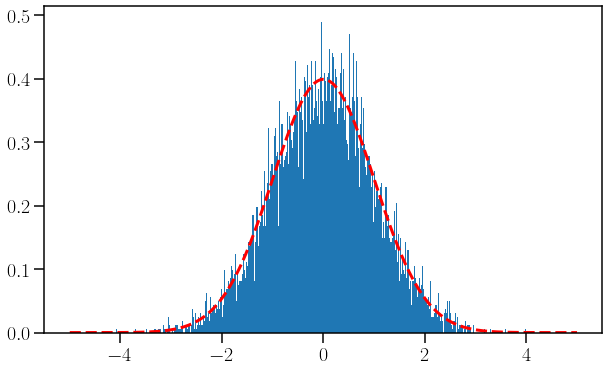

In [18]:
stdDev = np.mean(np.sqrt(listVar))
Z= [(listMean-ExpVal)/(stdDev/np.sqrt(N)) for listMean in listMean]

xTest = np.linspace(-5 , 5 , 1000)
yTest = gauss(xTest, 0, 1)


plt.plot(xTest, yTest, "--", color =  "red", lw = 3)
plt.hist(Z, density = True, bins = 500)

c) Compute the variance of 〈e〉 and compare it with the value you expect.

In [19]:
np.var(listMean)/(sigmaCLT**2)

1.0129178796785834

# Task 3

a) What is the expected p.d.f. for the number of entries per bin?

the number of entries per bin is large => Gaussian with mean $f$. Let's compute the chi2 for one experiment ang generalise later.

Text(0.5, 1.0, 'Comparaison of Poisson and Normal')

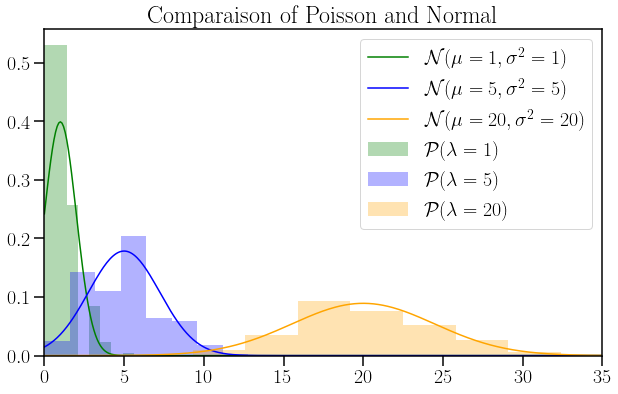

In [21]:
xPoisson = np.linspace(0,40, 400)
plt.hist(np.random.poisson(1,10000) ,alpha = 0.3, color = "green"   , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=1)$")
plt.hist(np.random.poisson(5,10000) ,alpha = 0.3, color = "blue"    , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=5)$")
plt.hist(np.random.poisson(20,10000),alpha = 0.3, color = "orange"  , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=20)$")

plt.plot(xPoisson,gauss(xPoisson,1,np.sqrt(1)), color = "green", label = "$\mathcal{N}(\mu =1, \sigma^2 = 1)$")
plt.plot(xPoisson,gauss(xPoisson,5,np.sqrt(5)), color = "blue", label = "$\mathcal{N}(\mu=5, \sigma^2 = 5)$")
plt.plot(xPoisson,gauss(xPoisson,20,np.sqrt(20)), color = "orange", label = "$\mathcal{N}(\mu=20, \sigma^2 = 20) $")

plt.legend( )
plt.xlim(0,35)
plt.title("Comparaison of Poisson and Normal")

15.90753123158046

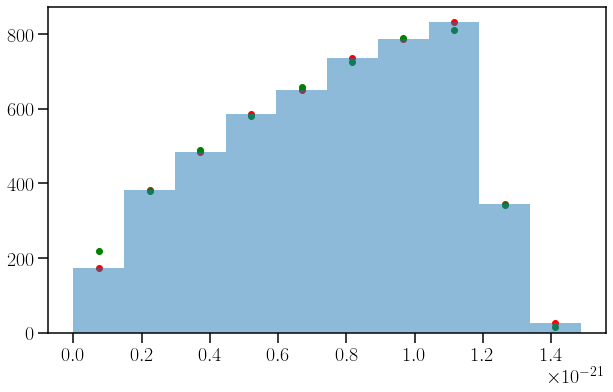

In [145]:
Nexp=1
N=5000
data = Egenerator(N,T)
nBins = 10

content,edges = np.histogram(data, bins = nBins, density=False)
width = edges[1]-edges[0]
xExp = edges[:-1] + width/2

    #Uncomment to see what happend
plt.hist(data, bins = nBins, density=False, alpha = 0.5)
plt.scatter(xExp, content, color = "red")
plt.scatter(xExp, N*f(xExp,T)*width, color = "green")


#The observed value is content[i] and the coordinate xExp[i]
#The expected value is f(epsilon, T) at xExp[i]
#Compute the difference

chi2 = 0
for j in range(len(content)):
    fj = N*f(xExp[j],T)*width
    dif = np.power((content[j]-fj),2)/fj
    chi2 = chi2 + dif

chi2

Define a function for it

In [146]:
def doChiBin(binContent, binEdges):
    w = binEdges[1]-binEdges[0]
    xc = binEdges[:-1] + w/2
    X = 0
    N
    for j in range(len(binContent)):
        fj = N*f(xc[j],T)*w
        d = np.power((binContent[j]-fj),2)/fj
        X = X + d
    return X

In [225]:
Nexp    = int(5000)
N       = int(2000)
nBins   = 10
chiList = np.zeros(Nexp)

for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList[i] =doChiBin(content, edges)
chiList = chiList[chiList< 45]

(0.0, 45.0)

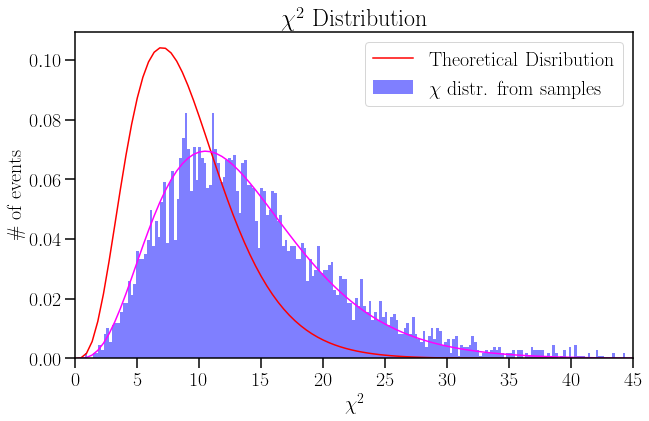

In [261]:
xChi = np.linspace(0,45,100)
yChi = stats.chi2.pdf(xChi, df = nBins-1, scale = 1)
yChi2 = stats.chi2.pdf(xChi, df = nBins-1, scale = 1.5)

plt.hist(chiList, density=True, bins = 200, color = "blue", alpha = 0.5, label = "$\chi$ distr. from samples")
plt.plot(xChi,yChi, color = "red", label = "Theoretical Disribution")
plt.plot(xChi,yChi2, color = "Magenta")

plt.title("$\chi^2$ Distribution")
plt.xlabel("$\chi^2$")
plt.ylabel("\# of events")
plt.legend()
plt.xlim(0,45)



In [ ]:
Nexp=5000
N=1000
chiList1 = np.zeros(Nexp)
chiList2 = np.zeros(Nexp)
chiList3 = np.zeros(Nexp)
chiList4 = np.zeros(Nexp)

nBins = 5
for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList1[i] =doChiBin(content, edges)
chiList1 = chiList1[chiList1< 50]

nBins = 10
for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList2[i] =doChiBin(content, edges)
chiList2 = chiList2[chiList2< 50]

nBins = 15
for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList3[i] =doChiBin(content, edges)
chiList3 = chiList3[chiList3< 50]

nBins = 25
for i in range(Nexp):
    dat = Egenerator(N,T)
    content,edges= np.histogram(dat, bins = nBins, density=False)
    chiList4[i] =doChiBin(content, edges)
chiList4 = chiList4[chiList4< 50]

In [ ]:
plt.hist(chiList1, density = True, bins = 40, alpha = 0.4, color = "blue"     , label = "$\chi^2$ for $N_{bins}=5$")
plt.hist(chiList2, density = True, bins = 40, alpha = 0.4, color = "orange"   , label = "$\chi^2$ for $N_{bins}=10$")
plt.hist(chiList3, density = True, bins = 40, alpha = 0.4, color = "green"    , label = "$\chi^2$ for $N_{bins}=15$")
plt.hist(chiList4, density = True, bins = 40, alpha = 0.4, color = "magenta"  , label = "$\chi^2$ for $N_{bins}=25$")

xChi = np.linspace(0,45,100)
yChi1 = stats.chi2.pdf(xChi,4)
yChi2 = stats.chi2.pdf(xChi,9)
yChi3 = stats.chi2.pdf(xChi,14)
yChi4 = stats.chi2.pdf(xChi,24)
plt.xlim(0,45)

plt.plot(xChi,yChi1, color = "blue")
plt.plot(xChi,yChi2, color = "orange")
plt.plot(xChi,yChi3, color = "green")
plt.plot(xChi,yChi4, color = "magenta")

plt.legend()
plt.title("Comparaison of $\chi^2$ from sample and Theory")
plt.xlabel("$\chi^2$ ")
plt.ylabel("\# of events")

# Task 4

a) Compute the log likelihood ln L(x1, x2, ..., xN | μ) at a given μ. Then, use the maximum
likelihood method to estimate μ and its variance

In [ ]:
N=2000
Nexp=500
nBins=20
data = Egenerator(N,T)
Ttest=np.linspace(0.5,7,300)

In [ ]:
def LLH(testData,Ttest):
    Loutput=0
    for i in range(0,len(testData)):
        Loutput+=math.log(f(testData[i],Ttest))
    return -Loutput

print (LLH(data,3))

In [ ]:
listLikeliHood = np.zeros(len(Ttest))

for i in range(len(Ttest)):
    l = LLH(data,Ttest[i])
    listLikeliHood[i] = l

Lmin = min(listLikeliHood)
indexLmin = (listLikeliHood.tolist()).index(Lmin)

for i in range(len(Ttest)): #Normalize
    listLikeliHood[i] -= Lmin

TParam = Ttest[indexLmin]
print (TParam,min(listLikeliHood))

i1=0
i2=0
for i in range(0,len(Ttest)-1):
    if listLikeliHood[i]>0.5 and listLikeliHood[i+1]<0.5:
        i1=i
    if listLikeliHood[i]<0.5 and listLikeliHood[i+1]>0.5:
        i2=i

err = (Ttest[i2]-Ttest[i1])/2

print ('The error of the estimation=',err)

In [ ]:
#plt.plot(Ttest,listLikeliHood,'-',lw=3)
plt.scatter(Ttest,listLikeliHood, s=3)
plt.scatter([TParam-err,TParam+err],[listLikeliHood[i1],listLikeliHood[i2]], color = "red")
plt.plot([TParam-err,TParam-err],[listLikeliHood[i1],50], "--",color = "red", alpha = 0.5)
plt.plot([TParam+err,TParam+err],[listLikeliHood[i2],50], "--",color = "red", alpha = 0.5)


plt.xlabel("$T$")
plt.ylabel("$-ln\ L+ln\ L_{min}$")
plt.title("The likelihood of T parameters")

plt.tick_params(direction='in')
plt.text(4,0.4, "$T_{estim} = $"+ str("{:.2f}".format(Ttest[indexLmin])) )
plt.text(4,0.1, "$\sigma = $"+ str("{:.2f}".format(err)) )
plt.text(TParam-0.25,60, "$2\sigma$", color ="red")

plt.semilogy()
plt.grid(True)
plt.ylim(0.005,1000)
print("mu = " , str("{:.2f}".format(30*kb*Ttest[indexLmin]*1e23)), "+-",str("{:.2f}".format(30*kb*err*1e23)) )
print("Expected result : ",  str("{:.2f}".format(mu*1e23)))

In [ ]:
result = np.zeros(Nexp)
stdResult = np.zeros(Nexp)

for i in range(Nexp):
    dat = Egenerator(N,T)
    listLikeliHood = np.zeros(len(Ttest))

    for j in range(len(Ttest)):
        l = LLH(dat,Ttest[j])
        listLikeliHood[j] = l

    Lmin = min(listLikeliHood)
    indexLmin = (listLikeliHood.tolist()).index(Lmin)
    TParam = Ttest[indexLmin]
    result[i] = TParam

    for k in range(len(Ttest)): #Normalize
        listLikeliHood[k] -= Lmin

    i1=0
    i2=0
    for l in range(0,len(Ttest)-1):
        if listLikeliHood[l]>0.5 and listLikeliHood[l+1]<0.5:
            i1=l
        if listLikeliHood[l]<0.5 and listLikeliHood[l+1]>0.5:
            i2=l
    err = (Ttest[i2]-Ttest[i1])/2
    stdResult[i] = err


In [ ]:
x = np.linspace(2,4,100)
y = gauss(x,3,np.mean(stdResult))
plt.hist(result, bins = 30, density=True, alpha = 0.7)
plt.plot(x,y, color = "red", label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")
plt.xlim(1.5,5.5)

plt.xlabel("Parameter estimation[K]")
plt.ylabel("\# Events")
plt.text(1.6, 2.2, "$N =$"+str("{:.0f}".format(N)))
plt.text(1.6, 1.8, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
plt.title("Estimated Parameter Distribution")
plt.legend(bbox_to_anchor=(0.45,0.95))


In [ ]:
cont,edg,_= plt.hist(result, bins = 60, density=True, alpha = 0.7)
plt.plot([Ttest[indexLmin],Ttest[indexLmin]],[0,1])

w=edg[1]-edg[0]
edgSum = edg[edg<Ttest[indexLmin]][1:]
pVal = np.sum(cont[:len(edgSum)])*w
print("The p-value of the estimation before is : "+str("{:.2f}".format(pVal*100)) + "%")


b) Compute the goodness of fit at various μ and use the least squares method to estimate μ
and its variance.

Let's now define a list of different $ \mu $  and for each one of them compute the least squares : 

$$
X = \sum (\dfrac{y(\epsilon)-f(\epsilon, T)}{\sigma})^2
$$

In [ ]:
def LeastSquare(data, nBins, params):
    content,edges = np.histogram(data, bins = nBins, density=False)
    width = edges[1]-edges[0]
    xExp = edges[:-1] + width/2
    yerr = np.sqrt(content)
    listX2 =  []
    for j in range(len(params)):
        c=0
        for i in range(len(content)):
            if(content[i]==0):
                dif=0
            else:
                fj = N*f(xExp[i], params[j])*width
                dif = np.power((content[i]-fj)/(yerr[i]),2)
                c+=dif
        listX2.append(c)
    return listX2

In [ ]:
x2List = LeastSquare(data, nBins, Ttest)
jmin = x2List.index(min(x2List))
x2Min = x2List[jmin]
parMin = Ttest[jmin]

for i in range(len(x2List)):
    x2List[i] = x2List[i]-x2Min

j1=0
j2=0
for i in range(len(Ttest)-1):
    if x2List[i]>1 and x2List[i+1]<1:
        j1=i
    if x2List[i]<1 and x2List[i+1]>1:
        j2=i

err = (Ttest[j2]-Ttest[j1])/2

plt.scatter(Ttest, x2List, s=3)
plt.scatter(Ttest[jmin], x2List[jmin], color = "green")
plt.scatter([parMin-err,parMin+err],[x2List[j1],x2List[j2]], color = "red")

plt.xlabel("T Parameter[K]")
plt.ylabel("Normalised $\chi^2$")
plt.title("Least Square of T parameters")
plt.semilogy()
plt.ylim(1e-3,1e3)
plt.grid()

plt.plot([parMin-err,parMin-err],[x2List[j1],50], "--",color = "red", alpha = 0.5)
plt.plot([parMin+err,parMin+err],[x2List[j2],50], "--",color = "red", alpha = 0.5)

plt.text(3.7,0.35, "$T_{estim} = $"+ str("{:.2f}".format(parMin)) )
plt.text(parMin-0.25,60, "$2\sigma$", color ="red")
plt.text(3.7,0.1, "$\sigma = $"+ str("{:.2f}".format(err)) )


print("mu = " , str("{:.2f}".format(30*kb*parMin*1e23)), "+-",str("{:.2f}".format(30*kb*err*1e23)) )
print("Expected result : ",  str("{:.2f}".format(mu*1e23)))


In [ ]:
resultx2 = np.zeros(Nexp)
stdResultx2 = np.zeros(Nexp)

for i in range(len(resultx2)):
    dat = Egenerator(N,3)
    ls = LeastSquare(dat, nBins, Ttest)
    jmin = ls.index(min(ls))
    x2Min = ls[jmin]
    resultx2[i] = Ttest[jmin]

    for j in range(len(ls)):
        ls[j] = ls[j]-x2Min
    j1=0
    j2=0
    for k in range(len(Ttest)-1):
        if ls[k]>1 and ls[k+1]<1:
            j1=k
        if ls[k]<1 and ls[k+1]>1:
            j2=k
    err = (Ttest[j2]-Ttest[j1])/2
    stdResultx2[i] = err

In [ ]:
x = np.linspace(2,4,100)
y = gauss(x,3,np.mean(stdResultx2))
plt.hist(resultx2, bins = 15, density=True, alpha = 0.7)
plt.plot(x,y, color = "red"   , label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")
plt.xlim(2,4)

plt.xlabel("Parameter estimation")
plt.ylabel("\# Events")
plt.title("Estimated Parameter Distribution")


#plt.text(1.6, 3, "$N =$"+str("{:.0f}".format(N)))
#plt.text(1.6, 2.5, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
#plt.legend(bbox_to_anchor=(0.45,0.95))

c) The parameter μ can also be estimated by computing the sample mean 〈e〉 of Eq. (1) with
the MC integral. Perform this estimation of μ and its corresponding variance.

We use : (x_i distriuted as f, energy)

$$
E_f(x)= \int_0^{2\mu} x\cdot f(x) dx \approx \dfrac{1}{N}\sum_{i=1}^N h(x_i)
$$

In [ ]:
dat     = data
MCest   = (1/N)*np.sum(dat)
MCvar   = (1/N)*np.sum(np.power(dat,2))-np.power(MCest,2)
MCstd   = np.sqrt(MCvar)/np.sqrt(N)

xxx = Ttest
yyy = (3/5)*30*kb*xxx

estmu   = (5/3)*MCest
mustd   = (5/3)*MCstd
TMC     = (5/(3*30*kb))*MCest
varT    = (5/(3*30*kb))*MCstd

print("T = "  +str("{:.2f}".format(TMC))        + " +- " +str("{:.2f}".format(varT)))
print("mu = " +str("{:.2f}".format(estmu*1e23)) + " +- " +str("{:.2f}".format(mustd*1e23)))

xFillest = [0,TMC+varT,TMC-varT,0]
yFillest = [MCest+MCstd,MCest+MCstd,MCest-MCstd,MCest-MCstd]
xFillT = [TMC-varT, TMC-varT, TMC+varT, TMC+varT]
yFillT = [0,MCest-MCstd,MCest+MCstd,0]


plt.plot(xxx,yyy, label = "Expect.Value")
plt.plot([0,TMC],[MCest,MCest], "--"    , color = "red"     , alpha = 0.7, label = r"$\langle\epsilon\rangle$")
plt.scatter(TMC, (3/5)*30*kb*TMC        , color = "red")
plt.plot([TMC,TMC],[0,MCest]    , "--"  , color = "green"   , alpha = 0.7, label = r"$T_{estim}$")

plt.title("Method of Moments")
plt.xlabel("T [K]")
plt.ylabel("MC estimator $[\epsilon]$")


plt.text(4,0.5e-21,"$T_{estim}$ = " + str("{:.2f}".format(TMC)))
plt.text(4,0.3e-21,"$\sigma$ = " + str("{:.2f}".format(varT)))

plt.legend()



In [ ]:
means   = np.zeros(Nexp)
vars    = np.zeros(Nexp)
for i in range(Nexp):
    dat     = Egenerator(N,T)
    MCest   = (1/N)*np.sum(dat)
    MCvar   = (1/N)*np.sum(np.power(dat,2))-np.power(MCest,2)
    MCstd   = np.sqrt(MCvar)

    TMC     = (5/(3*30*kb))*MCest
    varT    = (5/(3*30*kb))*MCstd

    means[i] = TMC
    vars[i] = varT

In [ ]:
x = np.linspace(2.6,3.3,100)
y = gauss(x,3,np.mean(vars)/np.sqrt(N))

plt.hist(means, bins = 20, density=True, alpha = 0.7, label = "Param. Estim.")

plt.plot(x,y,       color = "red"   , label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")
plt.xlim(2.7,3.7)

plt.xlabel("Parameter estimation [K]")
plt.ylabel("\# Events")
plt.text(3.2, 3, "$N =$"+str("{:.0f}".format(N)))
plt.text(3.2, 1, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
plt.title("Estimated Parameter Distribution")
plt.legend(bbox_to_anchor=(0.39,0.8))

# Task 5 

In [ ]:
N=1000
data_1 = np.sort(Egenerator(N,3))  #Generate the data and sort it.
data_2 = np.sort(Egenerator(N,3))
data_conc = np.sort(np.concatenate((data_1, data_2)))

x = np.linspace(0,2*mu,len(data_1))

#print("data_1 :\n{}".format(data_1))
#print(20*'-')
#print("data_2 :\n{}".format(data_2))
#print(20*'-')
#print("data_conc :\n{}".format(data_conc))

In [ ]:
# Compute the cumulative function using scipy "percentileofscore"

data_1_cum = [stats.percentileofscore(data_1, i)/100 for i in x]
#print('data_1_cum:\n{}'.format(data_1_cum))
#print(20*'-')

data_2_cum = [stats.percentileofscore(data_2, i)/100 for i in x]
#print('data_2_cum:\n{}'.format(data_2_cum))
#print(20*'-')

In [ ]:
plt.plot(x,data_1_cum, label = "Data 1")
plt.plot(x,data_2_cum, label = "Data 2")

plt.xlabel("$\epsilon$")
plt.ylabel("$\int_0^{\epsilon} f(\epsilon',T) \,d\epsilon'$")
plt.title("Cumulative probability")


In [ ]:
# Compute the (absolute difference) : 

data_diff = np.abs(np.subtract(data_1_cum, data_2_cum))
#print('data_diff:\n{}'.format(data_diff))

# Compute the max difference :
max_diff = max(data_diff)
max_diff

In [ ]:
# Compute the (absolute difference) : 

data_diff = np.abs(np.subtract(data_1_cum, data_2_cum))
#print('data_diff:\n{}'.format(data_diff))

# Compute the max difference :
max_diff = max(data_diff)
max_diff

In [ ]:
# Compute the (absolute difference) : 

data_diff = np.abs(np.subtract(data_1_cum, data_2_cum))
#print('data_diff:\n{}'.format(data_diff))

# Compute the max difference :
max_diff = max(data_diff)
max_diff

In [ ]:
# Trying to use directly the 2-sample Kolmogorov test from scipy.stats:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
# https://stackoverflow.com/questions/39132469/how-to-interpret-scipy-stats-kstest-and-ks-2samp-to-evaluate-fit-of-data-t?rq=1

D_statistics, p_value = stats.ks_2samp(data_1,data_2) #D_statistics is the absolute max distance between the two samples

print('D_stats is :\n{}'.format(D_statistics), '\np_value is:\n{}'.format(p_value))

We see that we get almost the same result using stats.ks.2samp than with our hand-made method (compare D_stats with max_diff)

In [ ]:
alpha = [0.20, 0.15, 0.10, 0.05, 0.025, 0.01, 0.005, 0.001]
c_alpha = [1.073, 1.138, 1.224, 1.358, 1.628, 1.731, 1.949]

crit_value = []

for i in range(len(alpha)):
    crit = np.sqrt(-math.log(alpha[i]/2)*1/N)
    crit_value.append(np.round(crit,3))
print(crit_value)

# We then use that the null hypothesis (which is set as default as : "The two samples originate from the same distribution") is REJECTED if D_stats > values from wikipedia (https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)
for i in range(len(alpha)):
    if D_statistics > crit_value[i]:
        print('The null hypothesis is rejected at the level:\n{}'.format(alpha[i]))
    else : 
        print('We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:\n{}'.format(alpha[i]))

In [ ]:
# Generalizing for Nexp = 100
N_exp = 100
i = 1
max_dist =[]
pList = []

while i <= N_exp :     
    data_1 = np.sort(Egenerator(N,3))
    data_2 = np.sort(Egenerator(N,3))    
    D_stat, p_value = stats.ks_2samp(data_1, data_2)
    max_dist.append(D_stat)    
    pList.append(p_value)
    i = i+1
    

In [ ]:
# We can compare each of the D_stat value (for each exp) with the 95% confidence level (obtained by using the function we defined before):
# We use the percentileofscore function to see how many (in percentage) are below this value :

print('Crit value for alpha = 0.05 is :\n{}'.format(crit_value[3]))
percentile = stats.percentileofscore(max_dist, crit_value[3])

print('There are', percentile, "% of d <= crit_value : which means that in",percentile , "% of the cases, we cannot reject the null hypothesis that the two datasets originate from the same distribution, at confidence level 95%.")

In [ ]:
plt.scatter(range(len(pList)),pList)
plt.plot([0,100],[0.05,0.05], color = "red")
plt.semilogy()

In [ ]:
t = np.array(pList)[np.array(pList)<0.05]
print(str("{:.1f}".format(100*(1-len(t)/200))))


# Task 6

In [ ]:
data6       = Egenerator(1e4, T)
measured    = np.zeros(len(data6))
uncertainty = 2*kb*T

In [ ]:
for i in range(len(data6)):
    measured[i] = data6[i] + np.random.normal(0,uncertainty)
mesPos = measured[measured>=0]

plt.hist(data6      , density=True, bins = 30, color = "blue"  , alpha = 0.5)
plt.hist(measured   , density=True, bins = 30, color = "orange", alpha = 0.5)

In [ ]:
listLikeliHood = np.zeros(len(Ttest))

for i in range(len(Ttest)):
    l = LLH(mesPos,Ttest[i])
    listLikeliHood[i] = l

Lmin = min(listLikeliHood)
indexLmin = (listLikeliHood.tolist()).index(Lmin)

for i in range(len(Ttest)): #Normalize
    listLikeliHood[i] -= Lmin

TParam = Ttest[indexLmin]
print (TParam,min(listLikeliHood))

i1=0
i2=0
for i in range(0,len(Ttest)-1):
    if listLikeliHood[i]>0.5 and listLikeliHood[i+1]<0.5:
        i1=i
    if listLikeliHood[i]<0.5 and listLikeliHood[i+1]>0.5:
        i2=i

err = (Ttest[i2]-Ttest[i1])/2


print ('The error of the estimation=',err)


#plt.plot(Ttest,listLikeliHood,'-',lw=3)
plt.scatter(Ttest,listLikeliHood, s=3)
plt.scatter([TParam-err,TParam+err],[listLikeliHood[i1],listLikeliHood[i2]], color = "red")
plt.plot([TParam-err,TParam-err],[listLikeliHood[i1],50], "--",color = "red", alpha = 0.5)
plt.plot([TParam+err,TParam+err],[listLikeliHood[i2],50], "--",color = "red", alpha = 0.5)


plt.xlabel("$T$")
plt.ylabel("$-ln\ L+ln\ L_{min}$")
plt.title("The likelihood of T parameters")

plt.tick_params(direction='in')
plt.text(1,0.4, "$T_{estim} = $"+ str("{:.2f}".format(Ttest[indexLmin])) )
plt.text(1,0.1, "$\sigma = $"   + str("{:.2f}".format(err)) )
plt.text(TParam-0.25,60, "$2\sigma$", color ="red")

plt.semilogy()
plt.grid(True)
plt.ylim(0.005,1000)
print("mu = "               , str("{:.2f}".format(30*kb*Ttest[indexLmin]*1e23)), "+-",str("{:.2f}".format(30*kb*err*1e23)) )
print("Expected result : "  ,  str("{:.2f}".format(mu*1e23)))

In [ ]:
uncertainResultLLH = np.zeros(Nexp)
uncertainStdResultLLH = np.zeros(Nexp)

for i in range(Nexp):

    dat = Egenerator(N,T)
    measured    = np.zeros(len(dat))
    for n in range(len(dat)):
        measured[n] = dat[n] + np.random.normal(0,uncertainty)
    dat = measured[measured>=0]

    listLikeliHood = np.zeros(len(Ttest))
    
    for j in range(len(Ttest)):
        l = LLH(dat,Ttest[j])
        listLikeliHood[j] = l

    Lmin = min(listLikeliHood)
    indexLmin = (listLikeliHood.tolist()).index(Lmin)
    TParam = Ttest[indexLmin]
    uncertainResultLLH[i] = TParam

    for k in range(len(Ttest)): #Normalize
        listLikeliHood[k] -= Lmin

    i1=0
    i2=0
    for l in range(0,len(Ttest)-1):
        if listLikeliHood[l]>0.5 and listLikeliHood[l+1]<0.5:
            i1=l
        if listLikeliHood[l]<0.5 and listLikeliHood[l+1]>0.5:
            i2=l
    err = (Ttest[i2]-Ttest[i1])/2
    uncertainStdResultLLH[i] = err

In [ ]:
x = np.linspace(2,4,100)
y = gauss(x,3,np.mean(uncertainResultLLH))
plt.hist(uncertainResultLLH, bins = 30, density=True, alpha = 0.7, label = "Est.Param")
plt.plot(x,y, "--", color = "red", label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")
plt.xlim(1.5,5.5)

plt.xlabel("Parameter estimation[K]")
plt.ylabel("\# Events")
plt.text(1.6, 1.6, "$N =$"+str("{:.0f}".format(N)))
plt.text(1.6, 1.2, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
plt.title("Estimated Parameter Distribution")
plt.legend(bbox_to_anchor=(0.75,0.99))

b) Least Square

In [ ]:
x2List = LeastSquare(mesPos, nBins, Ttest)
jmin = x2List.index(min(x2List))
x2Min = x2List[jmin]
parMin = Ttest[jmin]

for i in range(len(x2List)):
    x2List[i] = x2List[i]-x2Min

j1=0
j2=0
for i in range(len(Ttest)-1):
    if x2List[i]>1 and x2List[i+1]<1:
        j1=i
    if x2List[i]<1 and x2List[i+1]>1:
        j2=i

err = (Ttest[j2]-Ttest[j1])/2

plt.scatter(Ttest, x2List, s=3)
plt.scatter(Ttest[jmin], x2List[jmin], color = "green")
plt.scatter([parMin-err,parMin+err],[x2List[j1],x2List[j2]], color = "red")

plt.xlabel("T Parameter[K]")
plt.ylabel("Normalised $\chi^2$")
plt.title("Least Square of T parameters")
plt.semilogy()
plt.ylim(1e-3,1e3)
plt.grid()

plt.plot([parMin-err,parMin-err],[x2List[j1],50], "--",color = "red", alpha = 0.5)
plt.plot([parMin+err,parMin+err],[x2List[j2],50], "--",color = "red", alpha = 0.5)

plt.text(1,0.35, "$T_{estim} = $"+ str("{:.2f}".format(parMin)) )
plt.text(1,0.1, "$\sigma = $"+ str("{:.2f}".format(err)) )
plt.text(parMin-0.25,60, "$2\sigma$", color ="red")

print("mu = " , str("{:.2f}".format(30*kb*parMin*1e23)), "+-",str("{:.2f}".format(30*kb*err*1e23)) )
print("Expected result : ",  str("{:.2f}".format(mu*1e23)))

In [ ]:
uncertainResultx2 = np.zeros(Nexp)
uncertainStdResultx2 = np.zeros(Nexp)

for i in range(len(uncertainResultx2)):
    dat = Egenerator(N,T)
    measured= np.zeros(len(dat))
    for n in range(len(dat)):
        measured[n] = dat[n] + np.random.normal(0,uncertainty)
    dat = measured[measured>=0]
    ls = LeastSquare(dat, nBins, Ttest)
    jmin = ls.index(min(ls))
    x2Min = ls[jmin]
    parMin = Ttest[jmin]
    uncertainResultx2[i] = parMin
    for j in range(len(ls)):
        ls[j] = ls[j]-x2Min
    j1=0
    j2=0
    for k in range(len(Ttest)-1):
        if ls[k]>1 and ls[k+1]<1:
            j1=k
        if ls[k]<1 and ls[k+1]>1:
            j2=k
    err = (Ttest[j2]-Ttest[j1])/2
    uncertainStdResultx2[i] = err/2

In [ ]:
x = np.linspace(2,4,100)
y = gauss(x,3,np.mean(uncertainStdResultx2))
plt.hist(uncertainResultx2, bins = 30, density=True, alpha = 0.7, label = "Est.Param")
plt.plot(x,y, "--", color = "red", label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")
plt.xlim(1.5,6)

plt.xlabel("Parameter estimation[K]")
plt.ylabel("\# Events")
plt.text(1.6, 1.6, "$N =$"+str("{:.0f}".format(N)))
plt.text(1.6, 1.2, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
plt.title("Estimated Parameter Distribution")
plt.legend(bbox_to_anchor=(0.45,0.99))

c) Method of moments

In [ ]:
dat     = measured
MCest   = (1/1e4)*np.sum(dat)
MCvar   = (1/1e4)*np.sum(np.power(dat,2))-np.power(MCest,2)
MCstd   = np.sqrt(MCvar)/np.sqrt(1e4)

xxx = Ttest
yyy = (3/5)*30*kb*xxx

estmu   = (5/3)*MCest
TMC     = (5/(3*30*kb))*MCest
varT    = (5/(3*30*kb))*MCstd

xFillest = [0,TMC+varT,TMC-varT,0]
yFillest = [MCest+MCstd,MCest+MCstd,MCest-MCstd,MCest-MCstd]
xFillT = [TMC-varT, TMC-varT, TMC+varT, TMC+varT]
yFillT = [0,MCest-MCstd,MCest+MCstd,0]

plt.plot(xxx,yyy)
plt.plot([0.5,TMC],[MCest,MCest], "--"  , color = "red"     , alpha = 0.7)
plt.scatter(TMC, (3/5)*30*kb*TMC        , color = "red")
plt.plot([TMC,TMC],[0,MCest]    , "--"  , color = "green"   , alpha = 0.7)

plt.fill(xFillest, yFillest             , color = "red"     , alpha = 0.3)
plt.fill(xFillT, yFillT                 , color = "green"   , alpha = 0.3)

plt.title("Method of Moments")
plt.xlabel("T [K]")
plt.ylabel("MC estimator $[\epsilon]$")

print("T = "  +str("{:.2f}".format(TMC))+ " +- " +str("{:.2f}".format(varT)))

In [ ]:
uncertainMeans   = np.zeros(Nexp)
uncertainVars    = np.zeros(Nexp)

for i in range(Nexp):
    dat = Egenerator(N,T)
    measured    = np.zeros(len(dat))
    for n in range(len(dat)):
        measured[n] = dat[n] + np.random.normal(0,uncertainty)
    dat = measured[measured>=0]
    MCest   = (1/N)*np.sum(dat)
    MCvar   = (1/N)*np.sum(np.power(dat,2))-np.power(MCest,2)
    MCstd   = np.sqrt(MCvar)

    TMC     = (5/(3*30*kb))*MCest
    varT    = (5/(3*30*kb))*MCstd

    means[i] = TMC
    vars[i] = varT

In [ ]:
x = np.linspace(2.6,3.3,100)
y = gauss(x,3,np.mean(vars)/np.sqrt(N))

plt.hist(means, bins = 50, density=True, alpha = 0.7, label = "Param. Estim.")

plt.plot(x,y,       color = "red"   , label = r"$\mathcal{N}(3,\langle\sigma\rangle)$")
plt.xlim(2.7,3.7)

plt.xlabel("Parameter estimation [K]")
plt.ylabel("\# Events")
plt.text(3.2, 3, "$N =$"+str("{:.0f}".format(N)))
plt.text(3.2, 1, "$N_{exp} =$"+str("{:.0f}".format(Nexp)))
plt.title("Estimated Parameter Distribution")
plt.legend(bbox_to_anchor=(0.39,0.8))